In [3]:
import pandas as pd
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import optuna
import numpy as np
import random
from tqdm import tqdm
import json
import seaborn as sns
import matplotlib.pyplot as plt



In [5]:
df = pd.read_csv("../datasets/train/final_labels.csv")
df = df[['body', 'level_1']].dropna()

new_df = pd.read_csv("../datasets/train/SD_dataset_FINAL.csv")
comments_df = pd.read_excel("../datasets/train/sampled_comments.xlsx")
submissions_df = pd.read_excel("../datasets/train/sampled_submissions.xlsx")

combined_new = pd.concat([comments_df, submissions_df], ignore_index=True)
combined_new['level_1'] = combined_new['label'].map({
    'Neutral': 'Nonmisogynistic',
    'Misogynistic': 'Misogynistic',
    'Mentions Misogyny': 'Misogynistic'
})

combined_new = combined_new[['body', 'level_1']].dropna()

new_df['level_1'] = new_df['level_1'].map({1: 'Misogynistic', 0: 'Nonmisogynistic'})
df = pd.concat([df, new_df], ignore_index=True)
df = pd.concat([df, combined_new], ignore_index=True)



In [6]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['level_1'])  # e.g., Nonmisogynistic = 1, Misogynistic = 0


dataset = Dataset.from_pandas(df[['body', 'label']])

dataset = dataset.train_test_split(test_size=0.2)
train_dataset = dataset['train']
test_dataset = dataset['test']

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "MilaNLProc/bert-base-uncased-ear-misogyny"
tokenizer = AutoTokenizer.from_pretrained(model_name)

#model = AutoModelForSequenceClassification.from_pretrained("misogyny-classifier")
#tokenizer = AutoTokenizer.from_pretrained("misogyny-classifier")

# 6. Tokenize the data
def tokenize_function(example):
    return tokenizer(example["body"], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


Map: 100%|██████████| 1660/1660 [00:00<00:00, 2169.71 examples/s]


In [1]:
import torch
print(torch.__version__)  # should show +cu118
print(torch.cuda.is_available())  # should be True
print(torch.cuda.get_device_name(0))  # should say "NVIDIA RTX A2000"


2.5.1+cu118
True
NVIDIA RTX A2000 8GB Laptop GPU


In [5]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
    }

def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 5),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
    }

# 8. Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs",
    metric_for_best_model="f1"
)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

training_args = TrainingArguments(output_dir="./eval", per_device_eval_batch_size=16)

# 9. Trainer
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

best_trial = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=hp_space,
    n_trials=10  # increase if you want a deeper search
)

print("Best trial:")
print(best_trial)

[I 2025-04-16 10:22:34,878] A new study created in memory with name: no-name-8fd9dafe-02a0-4827-bd35-be21eec159cd


Step,Training Loss
500,0.424800
1000,0.290100
1500,0.225700
2000,0.134100
2500,0.094000
3000,0.048600
3500,0.026800
4000,0.013400


[I 2025-04-16 11:27:22,941] Trial 0 finished with value: 3.719171682592723 and parameters: {'learning_rate': 3.303417251902611e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.2587659155636994}. Best is trial 0 with value: 3.719171682592723.


Step,Training Loss
500,0.288700
1000,0.043700


[I 2025-04-17 10:23:13,651] Trial 1 finished with value: 3.7254837478633664 and parameters: {'learning_rate': 2.597986092999817e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'weight_decay': 0.21556156972569296}. Best is trial 1 with value: 3.7254837478633664.


Step,Training Loss
500,0.359700


[I 2025-04-17 13:54:48,692] Trial 2 finished with value: 3.6920096618692573 and parameters: {'learning_rate': 1.203584371201866e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32, 'weight_decay': 0.013367669133077353}. Best is trial 1 with value: 3.7254837478633664.


Step,Training Loss
500,0.335600


[I 2025-04-17 14:18:50,175] Trial 3 finished with value: 3.705566446650404 and parameters: {'learning_rate': 4.665242795060328e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.1544565871189892}. Best is trial 1 with value: 3.7254837478633664.


Step,Training Loss
500,0.251400
1000,0.028400


[I 2025-04-17 20:59:25,479] Trial 4 finished with value: 3.715519580993015 and parameters: {'learning_rate': 4.198412275386926e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'weight_decay': 0.26068908183329836}. Best is trial 1 with value: 3.7254837478633664.


Step,Training Loss
500,0.338800


[I 2025-04-17 21:24:20,087] Trial 5 finished with value: 3.7187839338645414 and parameters: {'learning_rate': 4.126657308924073e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.20266728139124585}. Best is trial 1 with value: 3.7254837478633664.


Step,Training Loss
500,0.432500
1000,0.275800
1500,0.217200
2000,0.121100


[I 2025-04-17 22:03:37,447] Trial 6 finished with value: 3.731548718034847 and parameters: {'learning_rate': 3.197255355790083e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.07879902072783182}. Best is trial 6 with value: 3.731548718034847.


Step,Training Loss
500,0.351200


[I 2025-04-17 22:28:27,905] Trial 7 finished with value: 3.718159717856464 and parameters: {'learning_rate': 3.338812255864073e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.028692093202150645}. Best is trial 6 with value: 3.731548718034847.


Step,Training Loss
500,0.284200


[I 2025-04-18 02:13:48,587] Trial 8 finished with value: 3.717188746526795 and parameters: {'learning_rate': 2.750039799297207e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 32, 'weight_decay': 0.1565742174061875}. Best is trial 6 with value: 3.731548718034847.


Step,Training Loss


[I 2025-04-18 04:37:02,158] Trial 9 finished with value: 3.722779558995652 and parameters: {'learning_rate': 3.962522193834928e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 32, 'weight_decay': 0.011008868803692128}. Best is trial 6 with value: 3.731548718034847.


Best trial:
BestRun(run_id='6', objective=3.731548718034847, hyperparameters={'learning_rate': 3.197255355790083e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.07879902072783182}, run_summary=None)


In [7]:
# Step 1: Extract best params
best_params = best_trial.hyperparameters

# Step 2: Update training args with them
final_args = TrainingArguments(
    output_dir="./best_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_params["learning_rate"],
    per_device_train_batch_size=best_params["per_device_train_batch_size"],
    num_train_epochs=best_params["num_train_epochs"],
    weight_decay=best_params["weight_decay"],
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    logging_dir="./logs"
)

# Step 3: Create a new Trainer with best settings
final_trainer = Trainer(
    model_init=model_init,
    args=final_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Step 4: Train it!
final_trainer.train()

# Step 5 (optional): Save the model + tokenizer
final_trainer.save_model("best-misogyny-model")
tokenizer.save_pretrained("best-misogyny-model")


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.431600,0.298205,0.890964,0.936558,0.908226,0.966715
2,0.209200,0.394947,0.891566,0.935159,0.931133,0.939219
3,0.125300,0.580403,0.900000,0.940714,0.928773,0.952967


('best-misogyny-model\\tokenizer_config.json',
 'best-misogyny-model\\special_tokens_map.json',
 'best-misogyny-model\\vocab.txt',
 'best-misogyny-model\\added_tokens.json',
 'best-misogyny-model\\tokenizer.json')

In [9]:
# # 11. Evaluate
eval_result = final_trainer.evaluate()
print("Evaluation Results:", eval_result)

# # (Optional) Save model
# trainer.save_model("misogyny-classifier")
# tokenizer.save_pretrained("misogyny-classifier")

Evaluation Results: {'eval_loss': 0.5804033875465393, 'eval_accuracy': 0.9, 'eval_f1': 0.9407142857142857, 'eval_precision': 0.9287729196050776, 'eval_recall': 0.9529667149059334, 'eval_runtime': 60.4833, 'eval_samples_per_second': 27.446, 'eval_steps_per_second': 3.439, 'epoch': 3.0}


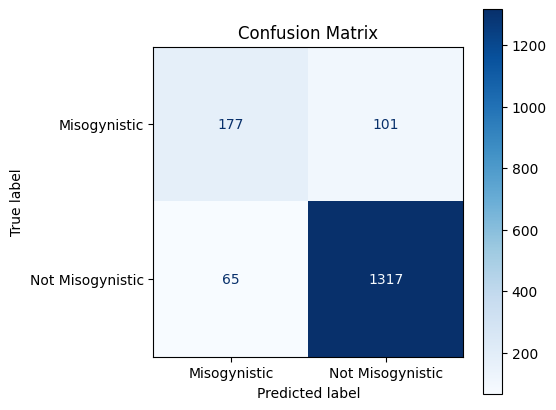

In [18]:
# this will run in batches under the hood and stay on GPU
predictions = final_trainer.predict(test_dataset).predictions  # shape [n_examples, n_labels]
pred_labels = np.argmax(predictions, axis=1)

# now build your confusion matrix:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_dataset["label"], pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=["Misogynistic","Not Misogynistic"])
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig("../images/bert-hypermarams-confusion.png")


In [9]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer
import torch
from datasets import load_dataset

# 1) Load the model & tokenizer from disk
model = AutoModelForSequenceClassification.from_pretrained("best-misogyny-model")
tokenizer = AutoTokenizer.from_pretrained("best-misogyny-model")

# 2) (Optional) Move model to GPU if available
device = 0 if torch.cuda.is_available() else -1

# 3) Load your dataset (replace this with the path to your dataset)
# Assuming the dataset is a HuggingFace dataset or a CSV file
# If using your own data, replace with appropriate dataset loading method
test_dataset = load_dataset('json', data_files='../datasets/test/womenEngineers_submission_filtered.json', split='test')

# Preprocess the dataset to match the model input format
def tokenize_function(example):
    return tokenizer(example['body'], padding=True, truncation=True, max_length=512)

test_dataset = test_dataset.map(tokenize_function, batched=True)

# 4) Re‑instantiate your Trainer for inference (don't need train/eval datasets if predicting only)
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="unused",       # This can be set to any valid path, but not used here.
        per_device_eval_batch_size=16,  # Adjust batch size as needed
        no_cuda=False,            # Set to True if you want to force CPU
        evaluation_strategy="no"  # Don't evaluate, just predict
    )
)

# 5) Run batched inference on your test dataset
preds = trainer.predict(test_dataset).predictions  # shape: [n_examples, n_labels]
pred_labels = preds.argmax(axis=-1)  # Get the label with the highest score for each sample

# 6) Optionally, process or save predictions as needed
test_dataset = test_dataset.add_column("predictions", pred_labels)

# Save results to a CSV if needed
import pandas as pd
df = pd.DataFrame(test_dataset)
df.to_csv('../datasets/results/bert_predictions.csv', index=False)

print(f"Predictions saved to ../datasets/results/bert_predictions.csv")


Generating train split: 0 examples [00:00, ? examples/s]Failed to load JSON from file 'C:\Users\AMcmaho2\programming\FYP\datasets\test\womenEngineers_submission_filtered.json' with error <class 'pyarrow.lib.ArrowInvalid'>: JSON parse error: Column(/created_utc) changed from string to number in row 47
Generating train split: 0 examples [00:00, ? examples/s]


DatasetGenerationError: An error occurred while generating the dataset